In [63]:
import numpy as np
import pandas as pd
import scipy as sp
import os

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz

import pydotplus

from imblearn.over_sampling import SMOTE

from patsy import dmatrices

import warnings
warnings.filterwarnings("ignore")

## Reading the Data

In [1]:
income = pd.read_csv("income_data.csv", sep=r'\s*,\s*', engine='python',na_values = '?')
income.head()

In [2]:
income.info()

# Q1
__1. Build visualizations and plots to see how the dependent variable varies with some of the other variables, such as 'education', 'marital-status', 'occupation', etc and study other interrelationships of the variables. Use them to tell a story/stories.__

__Visualizations__

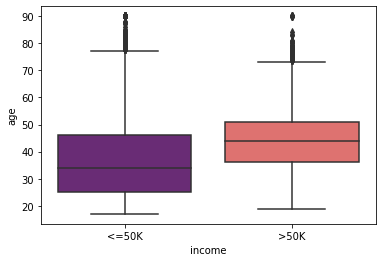

In [66]:
sns.boxplot(y="age", x="income", data=income,palette='magma')

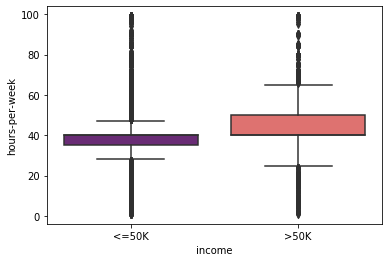

In [67]:
sns.boxplot(y="hours-per-week", x="income", data=income,palette='magma')

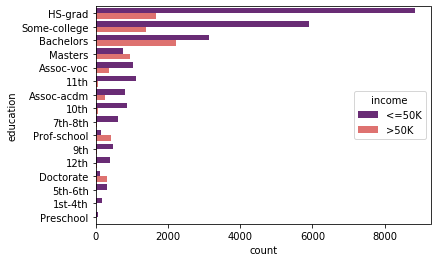

In [68]:
sns.countplot(y='education', hue='income', data = income, order = income['education'].value_counts().index,palette='magma')

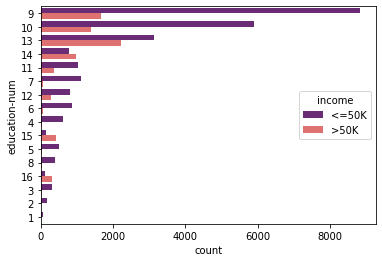

In [69]:
sns.countplot(y='education-num', hue='income', data = income, order = income['education-num'].value_counts().index,palette='magma')

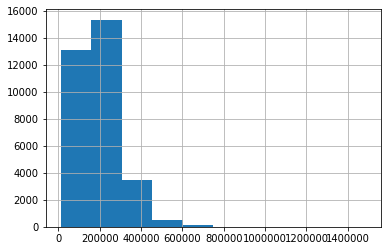

In [70]:
income['fnlwgt'].hist()

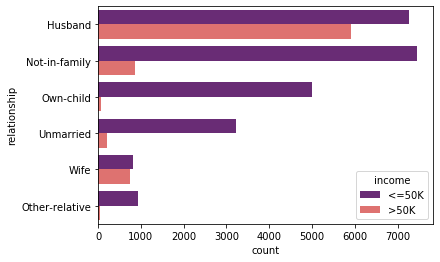

In [71]:
sns.countplot(y='relationship', hue='income', data = income, order = income['relationship'].value_counts().index,palette='magma')

[Text(0, 0, 'Female'), Text(0, 0, 'Male')]

<Figure size 720x360 with 0 Axes>

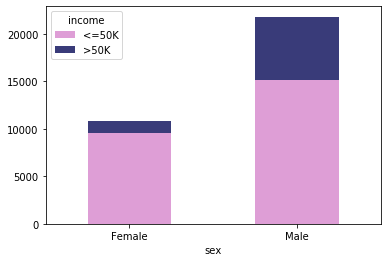

In [72]:
plt.figure(figsize=(10,5))
df_plot = income.groupby(['sex', 'income']).size().reset_index().pivot(columns='income', index='sex', values=0)
chart = df_plot.plot(kind='bar', stacked=True, colormap= 'tab20b_r')
chart.set_xticklabels(chart.get_xticklabels(), rotation=0)

[Text(0, 0, 'Adm-clerical'),
 Text(0, 0, 'Armed-Forces'),
 Text(0, 0, 'Craft-repair'),
 Text(0, 0, 'Exec-managerial'),
 Text(0, 0, 'Farming-fishing'),
 Text(0, 0, 'Handlers-cleaners'),
 Text(0, 0, 'Machine-op-inspct'),
 Text(0, 0, 'Other-service'),
 Text(0, 0, 'Priv-house-serv'),
 Text(0, 0, 'Prof-specialty'),
 Text(0, 0, 'Protective-serv'),
 Text(0, 0, 'Sales'),
 Text(0, 0, 'Tech-support'),
 Text(0, 0, 'Transport-moving')]

<Figure size 720x360 with 0 Axes>

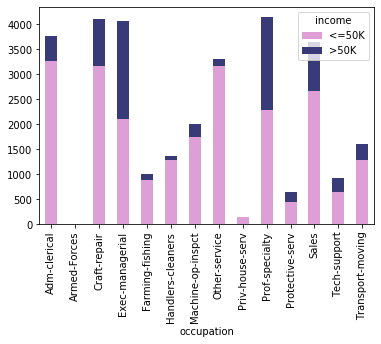

In [73]:
plt.figure(figsize=(10,5))
df_plot = income.groupby(['occupation', 'income']).size().reset_index().pivot(columns='income', index='occupation', values=0)
chart = df_plot.plot(kind='bar', stacked=True, colormap= 'tab20b_r')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

[Text(0, 0, 'Federal-gov'),
 Text(0, 0, 'Local-gov'),
 Text(0, 0, 'Never-worked'),
 Text(0, 0, 'Private'),
 Text(0, 0, 'Self-emp-inc'),
 Text(0, 0, 'Self-emp-not-inc'),
 Text(0, 0, 'State-gov'),
 Text(0, 0, 'Without-pay')]

<Figure size 720x360 with 0 Axes>

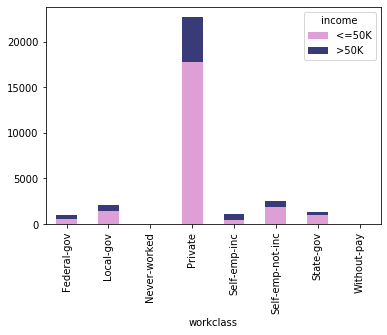

In [74]:
plt.figure(figsize=(10,5))
df_plot = income.groupby(['workclass', 'income']).size().reset_index().pivot(columns='income', index='workclass', values=0)
chart = df_plot.plot(kind='bar', stacked=True, colormap= 'tab20b_r')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

__Basic EDA__

In [75]:
#droping education num as it is the ordinal representation of education and no new information is captured
#droping fnlwgt as we dont see any patten in this parameter
income = income.drop(['education-num','fnlwgt','relationship'], axis=1)

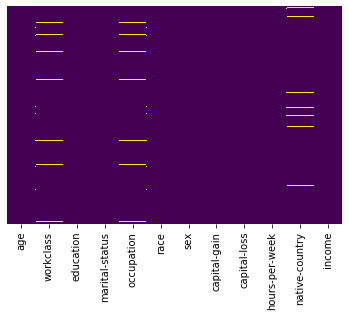

In [76]:
#Checking for nulls
income.isnull().values.any()
sns.heatmap(income.isnull(),yticklabels=False,cbar=False,cmap='viridis')

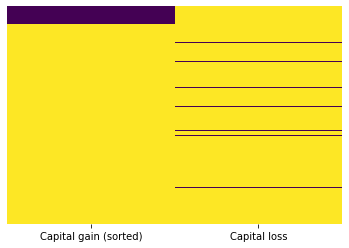

In [77]:
income_Cap=pd.DataFrame()
income_Cap["Capital gain (sorted)"]=income['capital-gain']
income_Cap["Capital loss"]=income['capital-loss']
income_Cap.replace(0, np.nan, inplace=True)
income_Cap=income_Cap.sort_values(by=['Capital gain (sorted)'])
sns.heatmap(income_Cap.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [78]:
#in case nulls need to be handled
for factor in factors:
    income[factor].fillna(value=income[factor].mode()[0], inplace=True)

# Q2
__2. How would you transform your categorical variables and why? Which of them would you transform? If you do not want to transform any, justify why.__

__Transformations__

Variable : education

In [80]:
#merging levels of education
not_hs_grad = ['11th', '9th', '10th', '12th', '7th-8th', '1st-4th', '5th-6th', 'Preschool']
education_dict = {}
for edu in list(income['education'].unique()):
    if edu not in not_hs_grad:
        education_dict[edu] = edu
    else:
        education_dict[edu] = 'Not-HS-Grad'
        
income['education'] = income['education'].map(education_dict)

Variable: workclass

In [81]:
income['workclass'].value_counts()

Private             24532
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [82]:
workclass_dict = {'Private': 'Private', 'Self-emp-not-inc': 'Self Employed', 'Local-gov': 'Government',
                 'State-gov': 'Government', 'Self-emp-inc': 'Self Employed', 'Federal-gov': 'Government',
                 'Without-pay': 'Other', 'Never-worked': 'Other'}

income['workclass'] = income['workclass'].map(workclass_dict)

Variable: Marital status

In [83]:
income['marital-status'].value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64

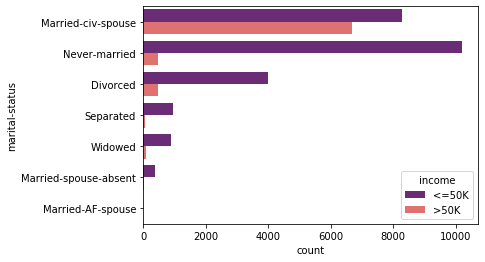

In [84]:
sns.countplot(y='marital-status', hue='income', data = income,order = income['marital-status'].value_counts().index,palette='magma')

In [85]:
status_dict = {}
for status in list(income['marital-status'].unique()):
    if 'Married' in status:
        status_dict[status] = 'Married'
    else:
        status_dict[status] = status
        
income['marital-status'] = income['marital-status'].map(status_dict)

Variable: native-country

In [86]:
income['native-country'] = np.where(income['native-country'] != 'United-States', 'Non-US', income['native-country'])

In [87]:
income['native-country'].value_counts()

United-States    29753
Non-US            2808
Name: native-country, dtype: int64

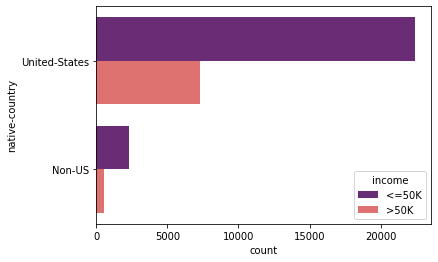

In [88]:
sns.countplot(y="native-country", hue="income", data=income,palette='magma')

Variable: Capital gain and capital loss 

In [89]:
income['Capital_Change'] = income['capital-gain']-income['capital-loss']
income = income.drop(['capital-gain','capital-loss'], axis=1)

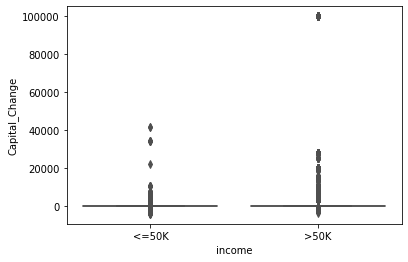

In [90]:
sns.boxplot(y="Capital_Change", x="income", data=income,palette='rainbow')

In [3]:
#assigning levels to the values of categorical variables
factors = ['workclass', 'education', 'marital-status', 'occupation','race', 'sex', 'native-country', 'income']
income_fact = income.copy()
mapping_levels = []
for factor in factors:
    income_fact[factor] = income_fact[factor].factorize(sort = True)[0]
    mapping_levels.append(income_fact[factor].factorize(sort = True)[1])
income_fact.head()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14f7b3890>,
      dtype=object)

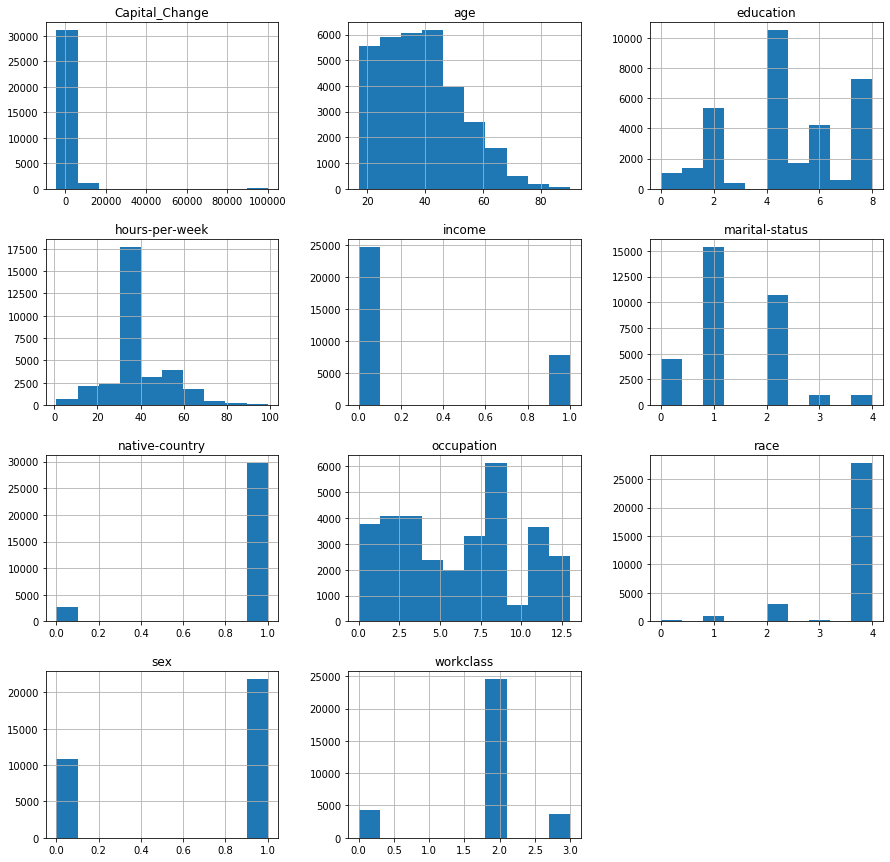

In [93]:
income_fact.hist(figsize=(15,15))

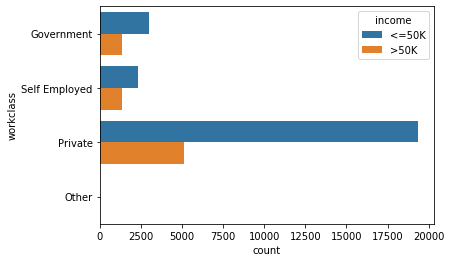

In [94]:
sns.countplot(y='workclass', hue='income', data = income)

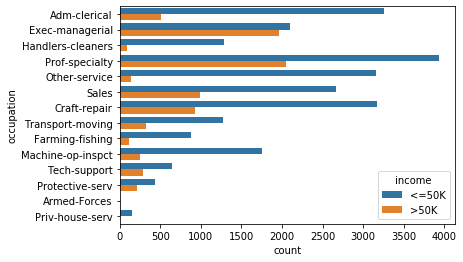

In [95]:
sns.countplot(y='occupation', hue='income', data = income)

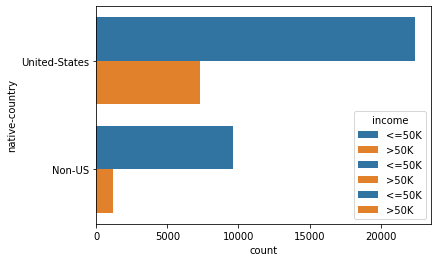

In [96]:
#missingdata visualization:
sns.countplot(y='race', hue='income', data = income)
sns.countplot(y='sex', hue='income', data = income)
sns.countplot(y='native-country', hue='income', data = income)

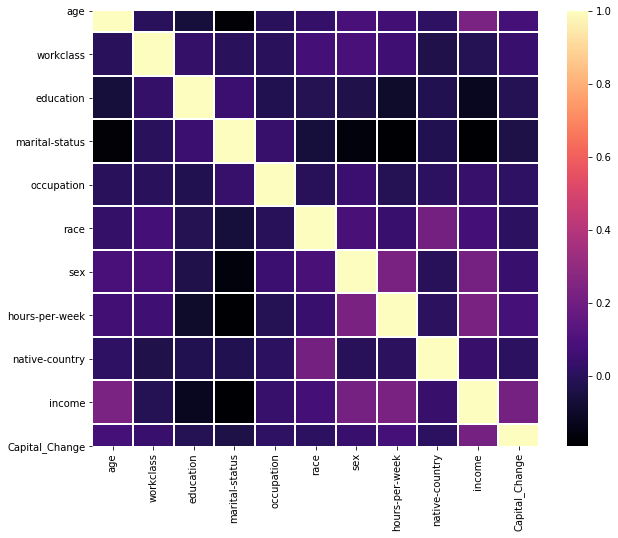

In [97]:
#correlation matrix of the data
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(income_fact.corr(),cmap='magma', linecolor='white',linewidths=1)

#There does not seem to be a strong observable correlation in this 

In [98]:
#checking for class imbalance
print(income['income'].value_counts())
print(str(round(income['income'].value_counts()[1]*100/income.shape[0],2)) + '%')

#We can see a clear imbalance

<=50K    24720
>50K      7841
Name: income, dtype: int64
24.08%


Text(0, 0.5, 'High Salary')

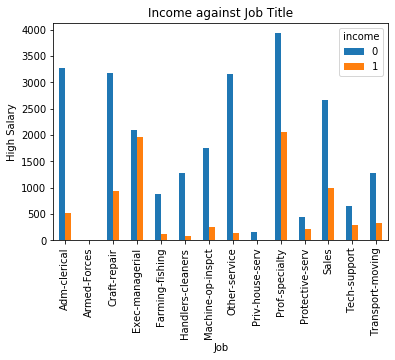

In [99]:
#determining if a variable is good predictor of income through plots
%matplotlib inline
pd.crosstab(income['occupation'],income_fact['income']).plot(kind='bar')
plt.title('Income against Job Title')
plt.xlabel('Job')
plt.ylabel('High Salary')

# Q3 & Q4
__3. Use a technique of your choice to eliminate some of the features. Explain your method.__

__4. Fit a regression model to predict whether income of an individual is more than 50k. What
regression model do you use? Why? How well is your model performing?__

__Creating Dummy Variables__

In [4]:
income_copy = income.copy()
for var in factors:
    if var != 'income':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(income_copy[var], prefix=var, drop_first = True)
        income_copy = pd.concat([income_copy,cat_list], axis = 1)#removing the base coloumn to account for multicollinearity problem
        income_copy = income_copy.drop(var, 1)
income_copy.head()

__Use Logistic Regression with all variables to predict__

In [101]:
#70% records being sent into training set 
income_copy['income'] = income_copy['income'].factorize()[0]
pts = np.random.rand(len(income_copy)) < 0.7

income_train = income_copy[pts]
income_test = income_copy[~pts]

X_train = income_train.copy()
X_train = X_train.drop('income', 1)
Y_train = income_train['income']

#fitting the model
lr1 = LogisticRegression(max_iter = 1000)
lr1.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [102]:
#generating confusion matrix
X_test = income_test.copy()
X_test = X_test.drop('income', 1)
Y_test = income_test['income']
Y_pred = lr1.predict(X_test)
confusion_matrix = confusion_matrix(Y_test, Y_pred)
c = classification_report(Y_test, Y_pred)
print(confusion_matrix)
print(c)

[[6825  530]
 [1024 1292]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      7355
           1       0.71      0.56      0.62      2316

    accuracy                           0.84      9671
   macro avg       0.79      0.74      0.76      9671
weighted avg       0.83      0.84      0.83      9671



In [103]:
from sklearn.metrics import roc_curve, auc
def draw_ROC_curve(y_test, X_test, title):
    '''
    Draw ROC curve
    '''
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test, lr1.predict_proba(X_test)[:,1])
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title(title)
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.2f'% roc_auc, color = 'purple')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()
    plt.close(0)

ROC for original model

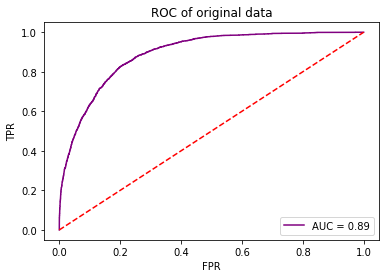

In [104]:
draw_ROC_curve(Y_test,X_test, 'ROC of original data')

__Accounting for oversampling__

In [105]:
from imblearn.over_sampling import SMOTE 
smote = SMOTE(random_state = 2) 
X_train_res, y_train_res = smote.fit_sample(X_train, Y_train.ravel()) 

In [106]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

After OverSampling, counts of label '1': 17365
After OverSampling, counts of label '0': 17365


In [107]:
lr1 = LogisticRegression(max_iter = 1000) 
lr1.fit(X_train_res, y_train_res.ravel()) 
predictions = lr1.predict(X_test) 
  
# print classification report 
print(classification_report(Y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      7355
           1       0.60      0.72      0.65      2316

    accuracy                           0.82      9671
   macro avg       0.75      0.78      0.77      9671
weighted avg       0.83      0.82      0.82      9671



ROC for oversampled model

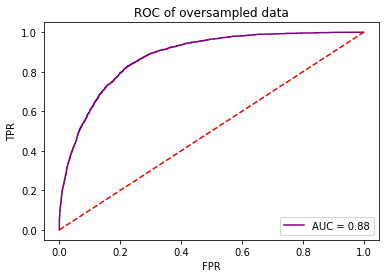

In [108]:
draw_ROC_curve(Y_test, X_test, 'ROC of oversampled data')

__Feature selection by Decision Tree__

In [109]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=0)
clf.fit(X_train_res, y_train_res)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [110]:
pd_dict = {'Features': X_train.columns, 'Importance': clf.feature_importances_}
feature = pd.DataFrame(pd_dict)
importance = feature.sort_values('Importance', ascending = False)
nodes = importance[importance['Importance'] != 0]
nodes

,Features,Importance
14,marital-status_Married,0.542394
2,Capital_Change,0.146052
11,education_Not-HS-Grad,0.116716
9,education_HS-grad,0.107281
15,marital-status_Never-married,0.087556


__The variables we obtain__

In [111]:
sel_factors = ['marital-status', 'Capital_Change', 'education', 'age', 'income']
cal_var = ['marital-status', 'education', 'income']

In [5]:
income_red = income.copy()
income_red = income_red[sel_factors]
for var in cal_var:
    if var != 'income':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(income_red[var], prefix=var, drop_first = True)
        income_red = pd.concat([income_red,cat_list], axis = 1)#removing the base coloumn to account for multicollinearity problem
        income_red = income_red.drop(var, 1)
income_red.head()

__Run logistic regression again on four selected variables__

In [113]:
#70% records being sent into training set 
income_red['income'] = income_red['income'].factorize()[0]
pts = np.random.rand(len(income_red)) < 0.7

income_train = income_red[pts]
income_test = income_red[~pts]

X_train = income_train.copy()
X_train = X_train.drop('income', 1)
Y_train = income_train['income']

X_test = income_test.copy()
X_test = X_test.drop('income', 1)
Y_test = income_test['income']

X_train_res_red, y_train_res_red = smote.fit_sample(X_train, Y_train.ravel()) 

lr1 = LogisticRegression(max_iter = 1000) 
lr1.fit(X_train_res_red, y_train_res_red.ravel()) 
predictions = lr1.predict(X_test) 
  
# print classification report 
print(classification_report(Y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      7401
           1       0.53      0.82      0.65      2397

    accuracy                           0.78      9798
   macro avg       0.73      0.79      0.74      9798
weighted avg       0.83      0.78      0.79      9798



In [114]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, predictions)

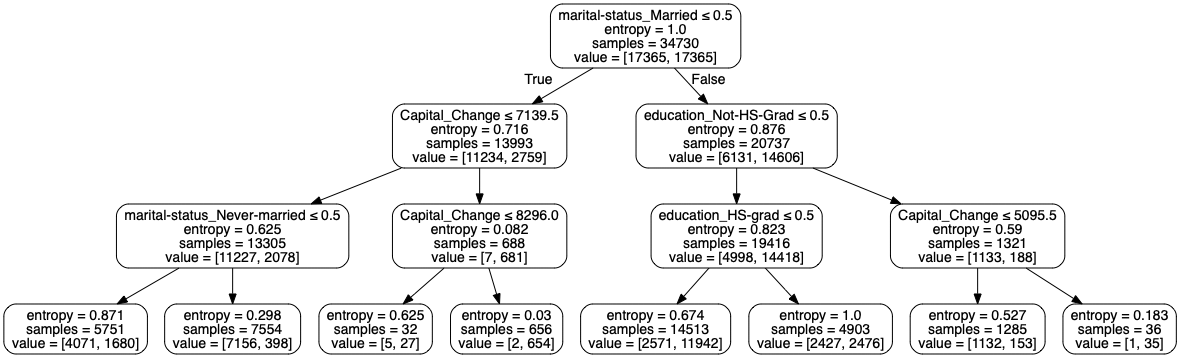

In [115]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                rounded=True,
                special_characters=True,feature_names = X_train_res.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

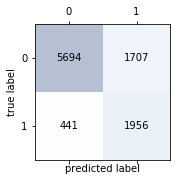

In [116]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i, s=confusion_matrix[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

ROC for oversampled model with reduced variables

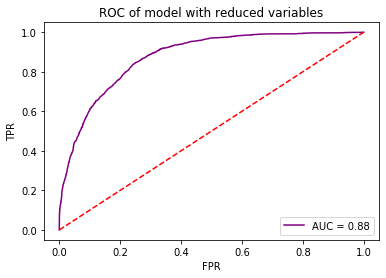

In [117]:
draw_ROC_curve(Y_test, X_test, 'ROC of model with reduced variables')

__Conclusion:__
    
__The ROC curve indicates that after oversampling, logistic regression on variables selected by Desicion Tree performs the best.__